# ノート 7: 複雑な回帰問題への ML の適用

### 目標: 複数の特徴量/予測変数/入力変数を使って ML の学習を行う

### 問題設定

1. 各画像は雷雲を含んでいるか（分類問題）
2. 各画像にはいくつの発雷があるか（回帰問題）

### 背景

先にノート 5 の内容を学習しておいてください。
このノートではノート 5 の内容を複数の変数を入直値とした ML に拡張してモデルの学習、評価、検証を行います。
ノート 6 とは扱う問題が回帰問題であることを除いて同じ手順です。


### Step 1 & 2: パッケージのインポートとデータの読み込み

すべての特徴量（36 個の特徴量）を使いましょう。ユーティリティ関数の `feature_to_keep` 引数を変更するだけです。
ノート 5 で観測された発雷が 0 のデータをあらかじめ除いておくとモデルの性能がよくなることが分かっています。
このため、`dropzeros` 引数を指定してあらかじめデータから除いておくことにします。


In [1]:
import matplotlib.pyplot as plt
import numpy as np


%config InlineBackend.figure_format = 'retina'

import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df

(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 36, 1),  # 0-35番目までの全特徴量を読み込む
    class_labels=False, # ラベルをクラス化しない
    dropzeros=True, # 発雷数0のデータを除く
)

データセットの形状が正しいか確認しましょう。


In [2]:
print("X_train, y_train shapes: {},{}".format(X_train.shape, y_train.shape))
print("X_val, y_val shapes: {},{}".format(X_validate.shape, y_validate.shape))
print("X_test, y_test shapes: {},{}".format(X_test.shape, y_test.shape))

X_train, y_train shapes: (222051, 36),(222051,)
X_val, y_val shapes: (46065, 36),(46065,)
X_test, y_test shapes: (48630, 36),(48630,)


ノート 6 よりサンプル数が少ないのは発雷数が 0 のデータをあらかじめ取り除いているからです。


#### ノート 5 からの変更点

複数の特徴量を用いる場合は正規化が重要になります。なぜ正規化が必要なのでしょうか？
一般に各入力変数がとる値の幅は異なり、大きく変化する変数もあれば変化が小さい変数もあります。
ML は入力変数に対する重みを学習します。正規化を行わない場合、変動幅が大きな変数に対する重みが大きくなり予測に対してバイアスを持つかもしれません（過学習）。
こうした影響を避けるために各入力変数を平均 0、分散 1 になるようにスケールします。
訓練データセットから求めた平均 $\mu$ 、標準偏差 $\sigma$ のときは、

$$ z=\frac{x-\mu}{\sigma} $$

と正規化します。
この正規化は scikit-learn では前処理を行うクラスとして用意されていて
`sklearn.preprocessing.StandardScalar` をモデルの学習前に適用するだけです。


In [3]:
from sklearn.preprocessing import StandardScaler

# Scalarクラスを訓練データに適合させる
scaler = StandardScaler()
scaler.fit(X_train)

# transform メソッドで特徴量をスケール
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

# 平均と標準偏差を確認
np.mean(X_train, axis=0), np.std(X_train, axis=0)

(array([ 7.74633690e-16, -1.56667488e-16, -2.87735713e-16, -2.57528583e-16,
         2.30393364e-17,  2.35513217e-17, -6.94380001e-17, -7.21899209e-17,
         1.77530887e-16,  2.40223481e-15, -6.88108182e-16, -4.63858640e-16,
        -6.53293185e-16,  3.88852801e-16, -4.31987558e-16, -2.67256303e-16,
         1.10550416e-15, -2.05306087e-16,  1.10076830e-17,  2.81591890e-18,
        -3.83988941e-17, -1.47195761e-16, -1.43355871e-17, -4.91505844e-17,
        -3.99348498e-17,  9.62532278e-17,  1.97370316e-16, -2.45752922e-17,
        -2.96951448e-17,  1.04956977e-17, -3.96788572e-18,  4.09588204e-18,
        -3.59029660e-17, -3.83988941e-19,  3.21270747e-17,  3.47637988e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]))

### Step 3: モデルの初期化

ノート 5 と同じく線形回帰モデルを使います。


In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
print(model)

LinearRegression()


### Step 4: モデルの学習


In [5]:
model = model.fit(X_train, y_train)

### Step 5: モデルの評価と検証

x 軸に予測された発雷数、y 軸に真の発雷数（検証データセットの発雷数）を取ってプロットしましょう。完全予測の場合は対角線に沿った分布になるはずです。


Text(0.5, 0, 'GLM measurement, [$number of flashes$]')

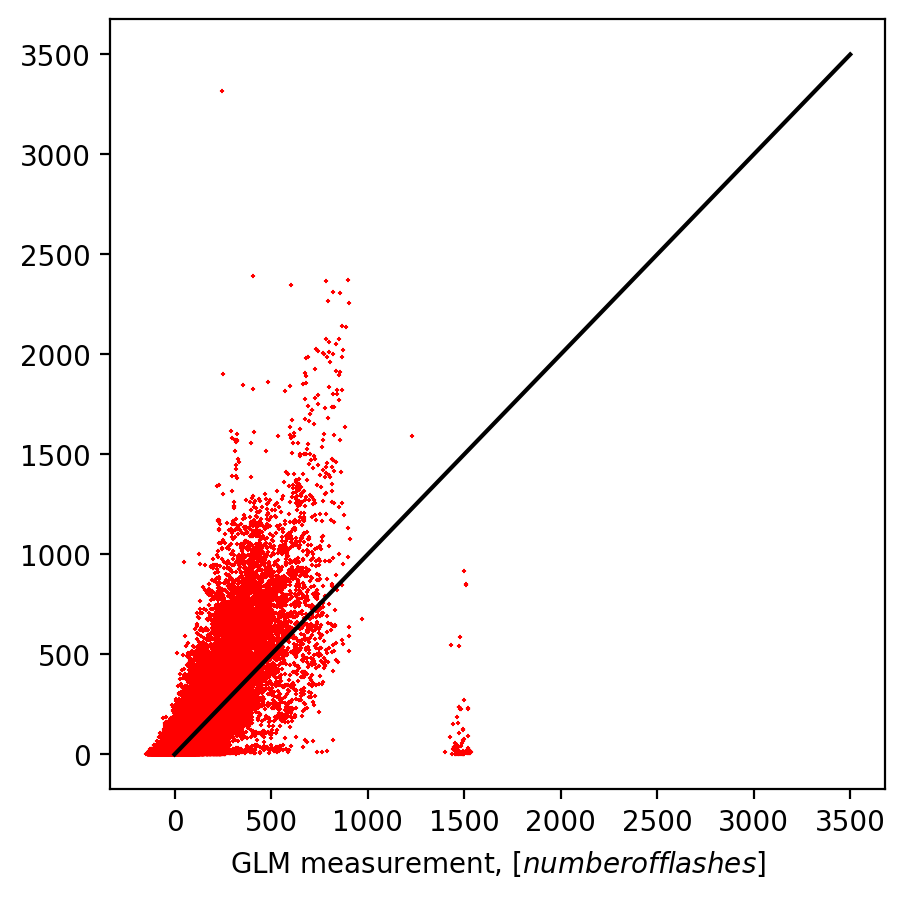

In [6]:
# 予測値の計算
yhat = model.predict(X_validate)

fig, ax = plt.subplots(figsize=(5, 5))

# 予測値（検証データのXからの予測） - 真値（検証データのy）をプロット
ax.scatter(yhat, y_validate, color="r", s=1, marker="+")
ax.plot([0, 3500], [0, 3500], "-k")  # 対角線
ax.set_xlabel("ML Prediction, [$number of flashes$]")
ax.set_xlabel("GLM measurement, [$number of flashes$]")

ノート 5 の 1 変数の場合より予測はよくなりました。
散布図では多くの点がプロットされているとモデルの「分布」が分かりづらい時があります。
分布を見て考察を深めるには論文の図 14 や 16 のように「分布密度」が表現された図を作成してみるのがいいでしょう。
ユーティリティ関数 `bixbin` を使ってプロットしてみましょう。
散布図を格子に分割して各格子にいくつの点が含まれるかを数えて密度としてプロットします。


n_samples= 26367.0


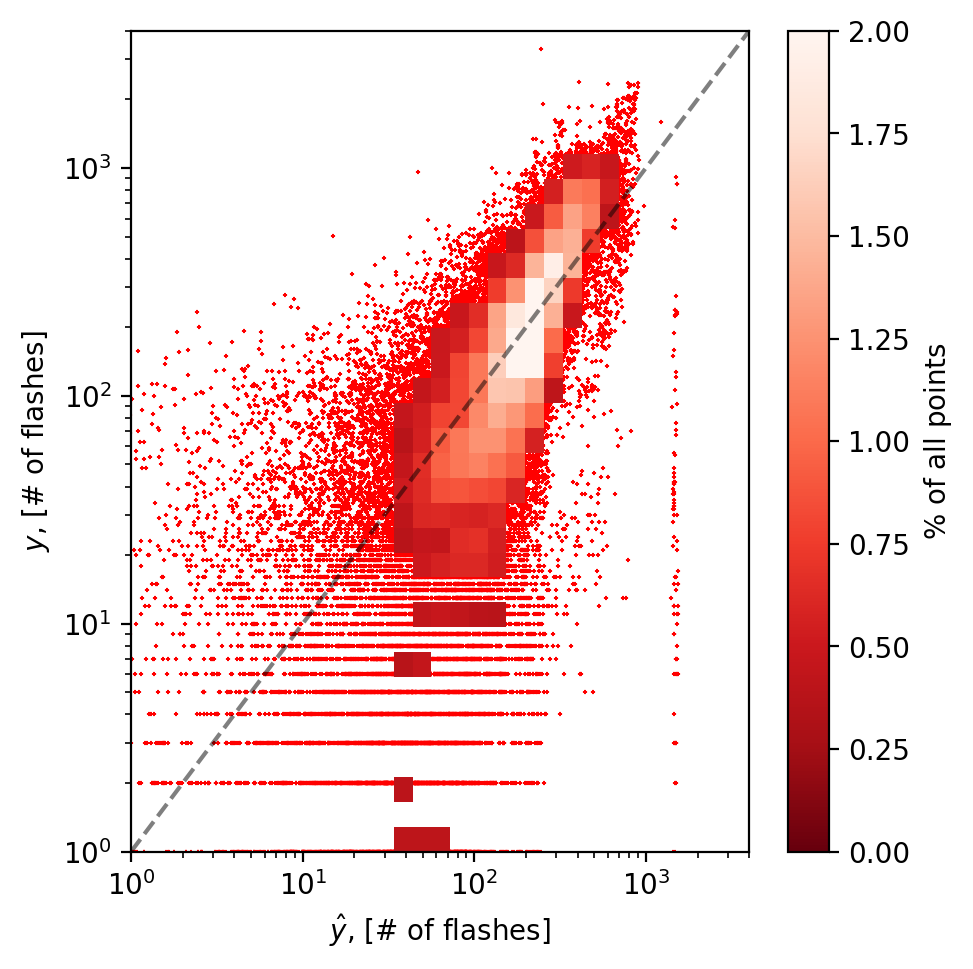

In [7]:
from aux_functions import boxbin

fig, ax = plt.subplots(figsize=(5, 5))

# 各軸方向の分割数、対数スケールで分割
n = 33
xbins = np.logspace(0, 3.5, n)
ybins = np.logspace(0, 3.5, n)

# 対数軸にする
ax.semilogy()
ax.semilogx()

# 散布図をプロット
ax.scatter(yhat, y_validate, color="r", s=1, marker="+")

# 格子単位でプロット
ax, cbar, C = boxbin(
    yhat,
    y_validate,
    xbins,
    ybins,
    ax=ax,
    mincnt=100,  # 格子を着色する含まれる点の数の下限
    normed=True,
    cmap="Reds_r",
    vmin=0,
    vmax=2,
)

cbar.set_label(r"$\%$ of all points")
ax.set_xlim([1, 4000])
ax.set_xticks([1, 10, 100, 1000])
ax.set_yticks([1, 10, 100, 1000])
ax.set_ylim([1, 4000])
ax.plot([1, 4000], [1, 4000], "--k", alpha=0.5)

ax.set_ylabel(r"$y$, [# of flashes]")
ax.set_xlabel(r"$\hat{y}$, [# of flashes]")

fig.tight_layout()

密度の高い領域が分かりやすくなりました（対数スケールでプロットしています）。100 個以上の点が含まれる領域が着色されています。

平均バイアス、平均絶対誤差（MAE）、二条平均誤差（RMSE）、決定係数（$R^2$）を計算しましょう。

$$\mathrm{Bias}=\frac{1}{N}\sum_{j=1}^N(y_{j}-\hat{y}_{j})$$

$$\mathrm{MAE}=\frac{1}{N}\sum_{j=1}^{N}|y_{j}-\hat{y}_{j}|$$

$$\mathrm{RMSE}=\sqrt{\frac{1}{N}\sum_{j=1}^N(y_j-\hat{y}_{j})^2}$$

$$\mathrm{R^2}=1-\frac{\sum_{j=1}^{N}(y_j-\hat{y}_j)^2}{\sum_{j=1}^{N}(y_{j}-\bar{y})^2}$$

ユーティリティ関数を使います。


In [8]:
from gewitter_functions import get_mae, get_rmse, get_bias, get_r2

yhat = model.predict(X_validate)
mae = get_mae(y_validate, yhat)
rmse = get_rmse(y_validate, yhat)
bias = get_bias(y_validate, yhat)
r2 = get_r2(y_validate, yhat)

print(
    "MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}".format(
        np.round(mae, 2), np.round(rmse, 2), np.round(bias, 2), np.round(r2, 2)
    )
)

MAE:90.56 flashes, RMSE:158.38 flashes, Bias:22.42 flashes, Rsquared:0.5


ノート 5 の結果と比べてみましょう。特徴量が 1 つだけの場合と比べて MAE、RMSE、バイアスは小さくなり$R^2$は大きくなりました。複数の特徴量を用いた方が予測性能が高くなったと評価できます。
線形モデルを衛星画像に含まれる発雷数のような非線形な現象に使うのはよい方法とは言えませんが、複数の特徴量を使えば（この例に関して言えば）それなりの予測性能が得られることが分かります。
